# Simulating the behavior of a single ant foraging for food and lays back pheromone on its way back

Code written using [`jax`](https://jax.readthedocs.io/) with `jit` capability for faster evaluation of functions, loops and gradients

&copy; S Ganga Prasath -- 16 Mar, 2023

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import jax.numpy as jnp
import jax
from jax import random
from jax import jit
from jax import vmap
from jax import lax
from jax.tree_util import register_pytree_node
import time
from typing import Tuple, Iterable
from functools import partial
from typing import NamedTuple, Any

In [2]:
colors = {
    "gray": {
        0: "#f8f9fa",
        1: "#f1f3f5",
        2: "#e9ecef",
        3: "#dee2e6",
        4: "#ced4da",
        5: "#adb5bd",
        6: "#868e96",
        7: "#495057",
        8: "#343a40",
        9: "#212529",
    },
    "red": {
        0: "#fff5f5",
        1: "#ffe3e3",
        2: "#ffc9c9",
        3: "#ffa8a8",
        4: "#ff8787",
        5: "#ff6b6b",
        6: "#fa5252",
        7: "#f03e3e",
        8: "#e03131",
        9: "#c92a2a",
    },
    "pink": {
        0: "#fff0f6",
        1: "#ffdeeb",
        2: "#fcc2d7",
        3: "#faa2c1",
        4: "#f783ac",
        5: "#f06595",
        6: "#e64980",
        7: "#d6336c",
        8: "#c2255c",
        9: "#a61e4d",
    },
    "grape": {
        0: "#f8f0fc",
        1: "#f3d9fa",
        2: "#eebefa",
        3: "#e599f7",
        4: "#da77f2",
        5: "#cc5de8",
        6: "#be4bdb",
        7: "#ae3ec9",
        8: "#9c36b5",
        9: "#862e9c",
    },
    "violet": {
        0: "#f3f0ff",
        1: "#e5dbff",
        2: "#d0bfff",
        3: "#b197fc",
        4: "#9775fa",
        5: "#845ef7",
        6: "#7950f2",
        7: "#7048e8",
        8: "#6741d9",
        9: "#5f3dc4",
    },
    "indigo": {
        0: "#edf2ff",
        1: "#dbe4ff",
        2: "#bac8ff",
        3: "#91a7ff",
        4: "#748ffc",
        5: "#5c7cfa",
        6: "#4c6ef5",
        7: "#4263eb",
        8: "#3b5bdb",
        9: "#364fc7",
    },
    "blue": {
        0: "#e7f5ff",
        1: "#d0ebff",
        2: "#a5d8ff",
        3: "#74c0fc",
        4: "#4dabf7",
        5: "#339af0",
        6: "#228be6",
        7: "#1c7ed6",
        8: "#1971c2",
        9: "#1864ab",
    },
    "cyan": {
        0: "#e3fafc",
        1: "#c5f6fa",
        2: "#99e9f2",
        3: "#66d9e8",
        4: "#3bc9db",
        5: "#22b8cf",
        6: "#15aabf",
        7: "#1098ad",
        8: "#0c8599",
        9: "#0b7285",
    },
    "teal": {
        0: "#e6fcf5",
        1: "#c3fae8",
        2: "#96f2d7",
        3: "#63e6be",
        4: "#38d9a9",
        5: "#20c997",
        6: "#12b886",
        7: "#0ca678",
        8: "#099268",
        9: "#087f5b",
    },
    "green": {
        0: "#ebfbee",
        1: "#d3f9d8",
        2: "#b2f2bb",
        3: "#8ce99a",
        4: "#69db7c",
        5: "#51cf66",
        6: "#40c057",
        7: "#37b24d",
        8: "#2f9e44",
        9: "#2b8a3e",
    },
    "lime": {
        0: "#f4fce3",
        1: "#e9fac8",
        2: "#d8f5a2",
        3: "#c0eb75",
        4: "#a9e34b",
        5: "#94d82d",
        6: "#82c91e",
        7: "#74b816",
        8: "#66a80f",
        9: "#5c940d",
    },
    "yellow": {
        0: "#fff9db",
        1: "#fff3bf",
        2: "#ffec99",
        3: "#ffe066",
        4: "#ffd43b",
        5: "#fcc419",
        6: "#fab005",
        7: "#f59f00",
        8: "#f08c00",
        9: "#e67700",
    },
    "orange": {
        0: "#fff4e6",
        1: "#ffe8cc",
        2: "#ffd8a8",
        3: "#ffc078",
        4: "#ffa94d",
        5: "#ff922b",
        6: "#fd7e14",
        7: "#f76707",
        8: "#e8590c",
        9: "#d9480f",
    },
    "mixed": {
        0: "#880e4f",
        1: "#1a237e",
        2: "#e65100",
        3: "#004d40",
        4: "#c92a2a",
    },
}

### [Useful resource](https://github.com/google/jax/issues/1567) on implementing `jax` with `jit` capability when handling class methods

In [91]:
class params():
    def __init__(self) -> None:
        super().__init__()
        self.nMax = 50
        self.dr = 0.25
        self.rInit = jnp.array([1., 1.])
        self.thetInit = 0.

class ant():
    def __init__(self, r, thet, rng):
        super().__init__()
        self.r = r
        self.thet = thet
        self.rng = rng
    
    @jit
    def stepFwd(self, dr) -> None:
        drng = random.split(self.rng)[0]
        new_thet = self.thet + random.uniform(drng, minval=-jnp.pi/8, maxval=jnp.pi/8)
        new_r = self.r + dr*jnp.array([jnp.cos(self.thet), jnp.sin(self.thet)])
        return ant(new_r, new_thet, drng)
    
register_pytree_node(ant,
                     lambda x: ((x.r[0], x.r[1], x.thet, x.rng), None),
                     lambda _, tup: ant(jnp.array([tup[0], tup[1]]), tup[2], tup[3]))


In [92]:
rng = random.PRNGKey(1)
p = params()
ag = ant(p.rInit, p.thetInit, rng)
start_time = time.time()
rxFull = np.array(p.rInit[0])
ryFull = np.array(p.rInit[1])
thetFull = np.array(p.thetInit)
for i in range(p.nMax):
    ag = ag.stepFwd(p.dr)
    rxFull = np.vstack((rxFull, np.array(ag.r[0])))
    ryFull = np.vstack((ryFull, np.array(ag.r[1])))
    thetFull = np.vstack((thetFull, np.array(ag.thet)))
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.1738576889038086 seconds ---


### Plotting trajectory of a single ant performing foraging

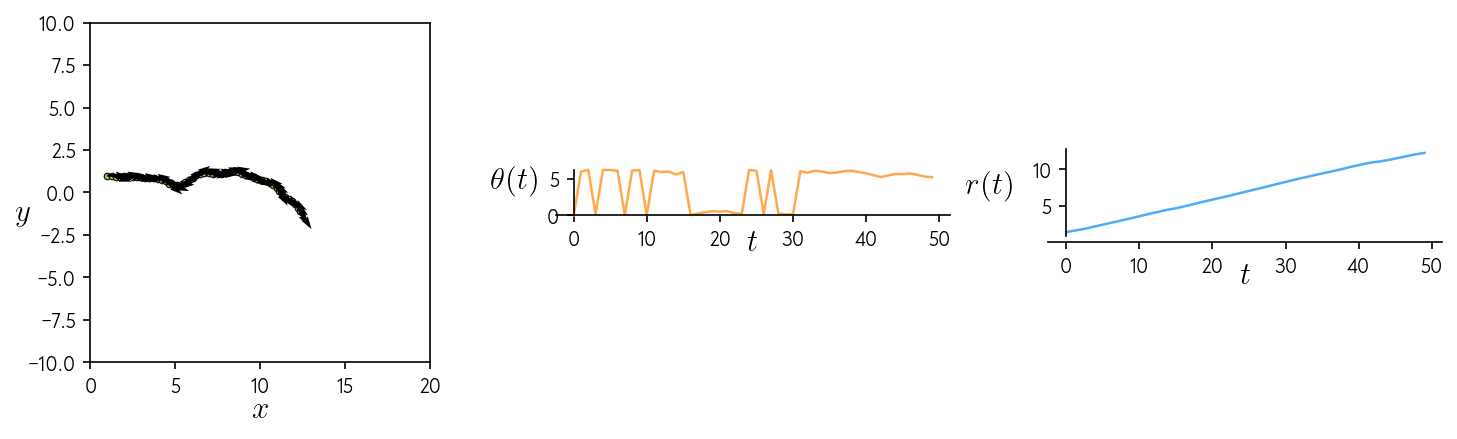

In [93]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rc("font", family="Noah")
plt.rc("xtick", labelsize="medium")

linewidth = 1.2
linestyle = "-"
label_size = 15
color = '#8dc63f'

fig = plt.figure(figsize=(10, 3), dpi=150)

nrows, ncols = 2, 2
gspec = gridspec.GridSpec(
    ncols=ncols, nrows=nrows, figure=fig, width_ratios=[1, 1], height_ratios=[1, 1]
)

nRow = 1
nCol = 3
ax1 = plt.subplot(nRow, nCol, 1, aspect=1)

ax1.scatter(rxFull, ryFull,
            s=10,
            color=color,
            edgecolors='k',
            linewidth=0.5,
            zorder=-1)
ax1.quiver(rxFull, ryFull,
           jnp.cos(thetFull), jnp.sin(thetFull),
           scale_units='xy', scale=0.8)
        #    , 'o', color=colors['orange'][4])
# ax1.set_xlim([0,2*p.nMax*p.dr])
# ax1.set_ylim([-p.nMax*p.dr,p.nMax*p.dr])
ax1.set_xlim([0., 20.])
ax1.set_ylim([-10., 10.])
ax1.set_xlabel(r'$x$',usetex=True, fontsize=label_size)
ax1.set_ylabel(r'$y$',usetex=True,rotation=0, fontsize=label_size)

ax1.xaxis.set_label_coords(0.5,-0.1)
ax1.yaxis.set_label_coords(-0.2,0.4)


ax2 = plt.subplot(nRow, nCol, 2, aspect=1)
t = jnp.arange(p.nMax)
ax2.plot(t, np.mod(thetFull[:-1],2*np.pi),
        color=colors['orange'][4],
        clip_on=False,
        linewidth=linewidth,
        linestyle=linestyle,)
ax2.set_xlabel(r'$t$',usetex=True, fontsize=label_size)
ax2.set_ylabel(r'$\theta(t)$',usetex=True,rotation=0, fontsize=label_size)
ax2.set_ylim([0.,2*np.pi])

ax2.xaxis.set_label_coords(0.5,-0.3)
ax2.yaxis.set_label_coords(-0.1,0.4)

ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.spines["left"].set_position(("data", 0))
ax2.spines["bottom"].set_position(("data", 0))

ax3 = plt.subplot(nRow, nCol, 3, aspect=1)
t = jnp.arange(p.nMax)
ax3.plot(t, np.sqrt(rxFull[:-1]**2 + ryFull[:-1]**2),
        color=colors['blue'][4],
        clip_on=False,
        linewidth=linewidth,
        linestyle=linestyle,)
ax3.set_xlabel(r'$t$',usetex=True, fontsize=label_size)
ax3.set_ylabel(r'$r(t)$',usetex=True,rotation=0, fontsize=label_size)
# ax3.set_ylim([0.,2*np.pi])

ax3.xaxis.set_label_coords(0.5,-0.3)
ax3.yaxis.set_label_coords(-0.15,0.4)

ax3.spines["right"].set_visible(False)
ax3.spines["top"].set_visible(False)
ax3.spines["left"].set_position(("data", 0))
ax3.spines["bottom"].set_position(("data", 0))


plt.tight_layout()
plt.show()

## Dynamics with return to home after reaching a distance $r^*$

In [108]:
class params():
    def __init__(self) -> None:
        super().__init__()
        self.nMax = 200
        self.dr = 0.5
        self.rInit = jnp.array([0., 0.])
        self.thetInit = 0.
        self.rSt = 10.0
        self.eps = 0.25

class antMotor():
    def __init__(self, r, thet, rng):
        super().__init__()
        self.r = r
        self.thet = thet
        self.rng = rng
    
    @jit
    def stepFwd(self, dr):
        drng = random.split(self.rng)[0]
        new_thet = self.thet + random.uniform(drng, minval=-jnp.pi/4, maxval=jnp.pi/4)
        new_r = self.r + dr*jnp.array([jnp.cos(self.thet), jnp.sin(self.thet)])
        return antMotor(new_r, new_thet, drng)
    
    @jit
    def homing(self, dr, new_thet):
        drng = random.split(self.rng)[0]
        new_r = self.r + dr*jnp.array([jnp.cos(new_thet), jnp.sin(new_thet)])  
        return antMotor(new_r, new_thet, drng)
    
register_pytree_node(antMotor,
                     lambda x: ((x.r[0], x.r[1], x.thet, x.rng), None),
                     lambda _, tup: antMotor(jnp.array([tup[0], tup[1]]), tup[2], tup[3]))


### Simple implementation of ant looping by going towards food and coming back home

In [32]:
rng = random.PRNGKey(0)
p = params()
ag = antMotor(p.rInit, p.thetInit, rng)
start_time = time.time()
rxFull = np.array(p.rInit[0])
ryFull = np.array(p.rInit[1])
thetFull = np.array(p.thetInit)
ind = 0
fStch = True
bStch = False
while ind < p.nMax:
    if jnp.sqrt(jnp.dot(ag.r, ag.r)) > p.rSt:
        fStch = False
        bStch = True
        new_thet = jnp.arctan2(ag.r[1],ag.r[0])
        new_thet -= jnp.pi
    elif (jnp.sqrt(jnp.dot(ag.r, ag.r)) < p.eps) & (bStch == True):
        bStch = False
        fStch = True
        # ag = ag.stepFwd(p.dr)
    
    if fStch == True:
        ag = ag.stepFwd(p.dr)
    if bStch == True:
        ag = ag.homing(p.dr, new_thet)
    
    rxFull = np.vstack((rxFull, np.array(ag.r[0])))
    ryFull = np.vstack((ryFull, np.array(ag.r[1])))
    thetFull = np.vstack((thetFull, np.array(ag.thet)))

    ind += 1

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.2547922134399414 seconds ---


### Ant senses using `sense()` function and takes motor action using `antMotor()`

In [127]:
def sense(ag, p, fStch, bStch, new_thet):
    rPos = np.sqrt(ag.r[0]**2 + ag.r[1]**2)
    # Check if ant is near home and coming with food
    if (rPos < p.eps) & bStch == True:
        fStch = True
        bStch = False
    # Check if ant is near food and coming from home
    elif ((rPos < (p.rSt+p.eps)) & (rPos > (p.rSt-p.eps))) & fStch == True:
        bStch = True
        fStch = False
        new_thet = np.arctan2(ag.r[1],ag.r[0])
        new_thet -= np.pi
    # Check if ant is coming from food and not near home
    return fStch, bStch, new_thet

In [128]:
rng = random.PRNGKey(0)
p = params()
ag = antMotor(p.rInit, p.thetInit, rng)
start_time = time.time()
rxFull = np.array(p.rInit[0])
ryFull = np.array(p.rInit[1])
thetFull = np.array(p.thetInit)
ind = 0
# Initialize forward motion
fStch = True
bStch = False
new_thet = ag.thet
while ind < p.nMax:
    fStch, bStch, new_thet = sense(ag, p, fStch, bStch, new_thet)
    if fStch == True:
        ag = ag.stepFwd(p.dr)
    if bStch == True:
        ag = ag.homing(p.dr, new_thet)    
    rxFull = np.vstack((rxFull, np.array(ag.r[0])))
    ryFull = np.vstack((ryFull, np.array(ag.r[1])))
    thetFull = np.vstack((thetFull, np.array(ag.thet)))
    ind += 1

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.3241147994995117 seconds ---


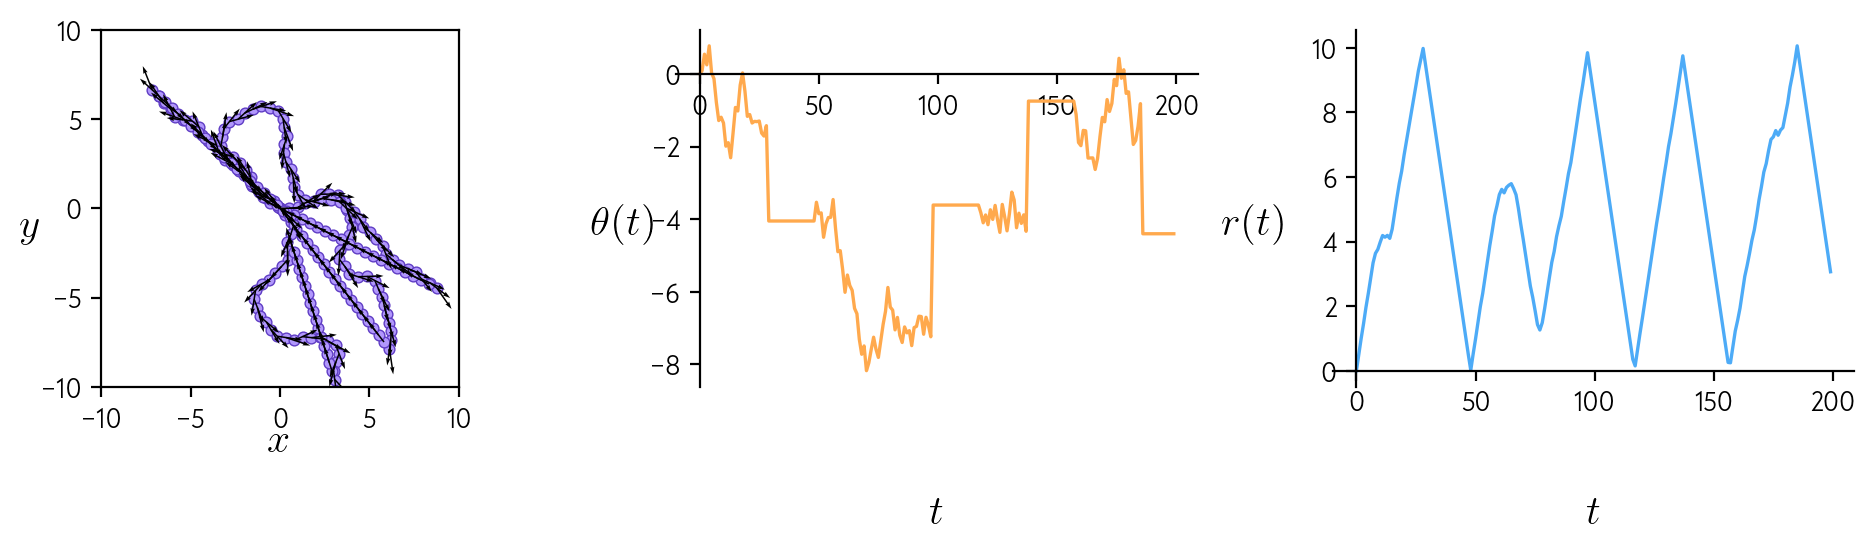

In [126]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rc("font", family="Noah")
plt.rc("xtick", labelsize="medium")

linewidth = 1.2
linestyle = "-"
label_size = 15
# color = '#8dc63f'
color = colors['violet'][3]

fig = plt.figure(figsize=(10, 3), dpi=200)
nrows, ncols = 2, 2
gspec = gridspec.GridSpec(
    ncols=ncols, nrows=nrows, figure=fig, width_ratios=[1, 1], height_ratios=[1, 1]
)

nRow = 1
nCol = 3
ax1 = plt.subplot(nRow, nCol, 1, aspect=1)

ax1.scatter(rxFull, ryFull,
            s=15,
            color=color,
            edgecolors=colors['violet'][9],
            linewidth=0.5,
            zorder=-1)
ax1.quiver(rxFull, ryFull,
           jnp.cos(thetFull), jnp.sin(thetFull),
           scale_units='xy', scale=0.7, color='k')
        #    , 'o', color=colors['orange'][4])
# ax1.set_xlim([0,2*p.nMax*p.dr])
# ax1.set_ylim([-p.nMax*p.dr,p.nMax*p.dr])
ax1.set_xlim([-10., 10.])
ax1.set_ylim([-10., 10.])
ax1.set_xlabel(r'$x$',usetex=True, fontsize=label_size)
ax1.set_ylabel(r'$y$',usetex=True,rotation=0, fontsize=label_size)

ax1.xaxis.set_label_coords(0.5,-0.1)
ax1.yaxis.set_label_coords(-0.2,0.4)


ax2 = plt.subplot(nRow, nCol, 2)
t = jnp.arange(p.nMax)
# ax2.plot(t, np.mod(thetFull[:-1],2*np.pi),
ax2.plot(t, thetFull[:-1],         
        color=colors['orange'][4],
        clip_on=False,
        linewidth=linewidth,
        linestyle=linestyle,)
ax2.set_xlabel(r'$t$',usetex=True, fontsize=label_size)
ax2.set_ylabel(r'$\theta(t)$',usetex=True,rotation=0, fontsize=label_size)
# ax2.set_ylim([0.,2*np.pi])

ax2.xaxis.set_label_coords(0.5,-0.3)
ax2.yaxis.set_label_coords(-0.1,0.4)

ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.spines["left"].set_position(("data", 0))
ax2.spines["bottom"].set_position(("data", 0))

ax3 = plt.subplot(nRow, nCol, 3)
t = jnp.arange(p.nMax)
ax3.plot(t, np.sqrt(rxFull[:-1]**2 + ryFull[:-1]**2),
        color=colors['blue'][4],
        clip_on=False,
        linewidth=linewidth,
        linestyle=linestyle,)
ax3.set_xlabel(r'$t$',usetex=True, fontsize=label_size)
ax3.set_ylabel(r'$r(t)$',usetex=True,rotation=0, fontsize=label_size)
# ax3.set_ylim([0.,2*np.pi])

ax3.xaxis.set_label_coords(0.5,-0.3)
ax3.yaxis.set_label_coords(-0.15,0.4)

ax3.spines["right"].set_visible(False)
ax3.spines["top"].set_visible(False)
ax3.spines["left"].set_position(("data", 0))
ax3.spines["bottom"].set_position(("data", 0))


plt.tight_layout()
plt.show()

### Function to plot data and save it as `.png`. Then convert the image sequence into a `.mp4` video

In [129]:
def plotFn(t, rxAll, ryAll, thetAll, fN, p):
    fig = plt.figure(figsize=(10, 3), dpi=200)
    color = colors['violet'][3]
    nRow = 1
    nCol = 3
    ax1 = plt.subplot(nRow, nCol, 1, aspect=1)
    
    
    ax1.scatter(rxAll[-1], ryAll[-1],
                s=15,
                color=color,
                edgecolors=colors['violet'][9],
                linewidth=0.5,
                zorder=-1)
    ax1.quiver(rxAll[-1], ryAll[-1],
            np.cos(thetAll[-1]), np.sin(thetAll[-1]),
            scale_units='xy', scale=0.7)
    ax1.set_xlim([-10., 10.])
    ax1.set_ylim([-10., 10.])
    ax1.set_xlabel(r'$x$',usetex=True, fontsize=label_size)
    ax1.set_ylabel(r'$y$',usetex=True,rotation=0, fontsize=label_size)

    ax1.xaxis.set_label_coords(0.5,-0.1)
    ax1.yaxis.set_label_coords(-0.2,0.4)


    ax2 = plt.subplot(nRow, nCol, 2)
    ax2.plot(t, np.mod(thetAll, 2*np.pi),         
            color=colors['orange'][4],
            clip_on=False,
            linewidth=linewidth,
            linestyle=linestyle,)
    ax2.plot(t[-1], np.mod(thetAll[-1], 2*np.pi), 'o', color=colors['orange'][4])
    ax2.set_xlabel(r'$t$',usetex=True, fontsize=label_size)
    ax2.set_ylabel(r'$\theta(t)$',usetex=True,rotation=0, fontsize=label_size)
    ax2.set_xlim([0., p.nMax])
    ax2.set_ylim([0., 2*np.pi])

    ax2.xaxis.set_label_coords(0.5,-0.3)
    ax2.yaxis.set_label_coords(-0.1,0.4)

    ax2.spines["right"].set_visible(False)
    ax2.spines["top"].set_visible(False)
    ax2.spines["left"].set_position(("data", 0))
    ax2.spines["bottom"].set_position(("data", 0))

    ax3 = plt.subplot(nRow, nCol, 3)
    ax3.plot(t, np.sqrt(rxAll**2 + ryAll**2),
            color=colors['blue'][4],
            clip_on=False,
            linewidth=linewidth,
            linestyle=linestyle,)
    ax3.set_xlabel(r'$t$',usetex=True, fontsize=label_size)
    ax3.set_ylabel(r'$r(t)$',usetex=True,rotation=0, fontsize=label_size)
    ax3.xaxis.set_label_coords(0.5,-0.3)
    ax3.yaxis.set_label_coords(-0.15,0.4)
    ax3.set_xlim([0., p.nMax])
    ax3.set_ylim([0., p.rSt+p.eps])

    ax3.spines["right"].set_visible(False)
    ax3.spines["top"].set_visible(False)
    ax3.spines["left"].set_position(("data", 0))
    ax3.spines["bottom"].set_position(("data", 0))

    plt.tight_layout()
    plt.savefig("Inter"+str(fN)+".png")
    plt.close()
    return

In [130]:
t = np.arange(p.nMax)
fN = 0
for ind in np.arange(1,p.nMax):
    plotFn(t[0:ind], rxFull[0:ind].flatten(), ryFull[0:ind].flatten(), thetFull[0:ind].flatten(), fN, p)
    fN +=1

/Users/kalyani/opt/anaconda3/lib/python3.9/site-packages/matplotlib/quiver.py:604: RuntimeWarning: invalid value encountered in divide
  lengths = np.hypot(*dxy.T) / eps


In [131]:
! rm SingleAnt.mp4
! ffmpeg -r 10 -i "Inter%d.png" -c:v libx264 -vf fps=10 -pix_fmt yuv420p ./SingleAnt.mp4

ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 14.0.0 (clang-1400.0.29.202)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/5.1.2_6 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack

In [132]:
!rm *.png